In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from keras.utils import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-files/df_test
/kaggle/input/test-files/df_sample
/kaggle/input/input-files/train_data.csv
/kaggle/input/input-files/test_data.csv


In [8]:
df_train = pd.read_csv('/kaggle/input/input-files/train_data.csv')
df_test = pd.read_csv('/kaggle/input/input-files/test_data.csv')

In [9]:
df_train = df_train[['Text','Category']]
df_test = df_test[['Text','Category']]

In [38]:
df_train.head(10)

,Text,Category
0,willis sues over movie injury actor bruce wi...,entertainment
1,souped-up wi-fi is on the horizon super high-s...,tech
2,apple unveils low-cost mac mini apple has un...,tech
3,blair rejects iraq advice calls tony blair has...,politics
4,quiksilver moves for rossignol shares of skis ...,business
5,cup holders man utd visit everton holders manc...,sport
6,us tv cuts nudity from bbc film a us tv networ...,entertainment
7,mobile audio enters new dimension as mobile ph...,tech
8,lib dems unveil election slogan the liberal de...,politics
9,india-pakistan peace boosts trade calmer relat...,business


In [10]:
df_train_category = df_train.groupby('Category').size().reset_index(name='count')
print(df_train_category.head())

        Category  count
0       business    228
1  entertainment    194
2       politics    188
3          sport    245
4           tech    188


In [11]:
df_train_category.head()

,Category,count
0,business,228
1,entertainment,194
2,politics,188
3,sport,245
4,tech,188


In [12]:
#type(df_train_category)
#print(df_train_category)
df_train_category = df_train_category.to_frame()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [ ]:
#import seaborn as sns
#df_train_category.reset_index()

In [13]:
import matplotlib.pyplot as plt
df_train_category['count']

0    228
1    194
2    188
3    245
4    188
Name: count, dtype: int64

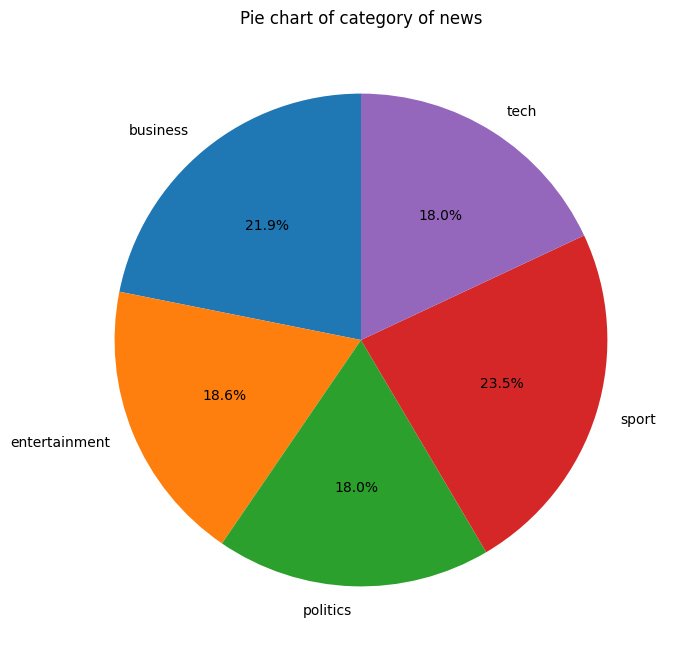

TypeError: 'DataFrame' object is not callable

In [17]:
plt.figure(figsize=(8, 8))  # Optional: Adjust figure size
plt.pie(df_train_category['count'], labels=df_train_category['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Pie chart of category of news')
plt.show()


<BarContainer object of 5 artists>

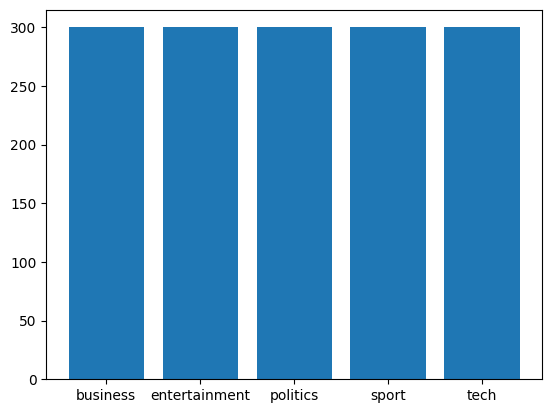

In [36]:

a = df_train_category['Category']
plt.bar(a,color = []  )


In [14]:
combined_stopwords = set(stopwords.words('english'))
text_cleaned = []
for i in range(len(df_train)):
    text = re.sub('[^a-zA-Z]', ' ', df_train['Text'][i])  
    text = text.lower()  
    text = text.split()  
    text = [word for word in text if word not in combined_stopwords]  
    cleaned_text = ' '.join(text)
    text_cleaned.append(cleaned_text)

text_cleaned1 = []
for i in range(len(df_test)):
    text1 = re.sub('[^a-zA-Z]', ' ', df_test['Text'][i])  
    text1 = text1.lower()  
    text1 = text1.split()  
    text1 = [word1 for word1 in text1 if word1 not in combined_stopwords]  
    cleaned_text1 = ' '.join(text1)
    text_cleaned1.append(cleaned_text1)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
text = text_cleaned
wordcloud = WordCloud().generate(text[2])
plt.imshow(wordcloud)
plt.show()

In [15]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')

tokenizer.fit_on_texts(text_cleaned)

max_length = max(len(seq.split()) for seq in text_cleaned)

sequences_encoded = tokenizer.texts_to_sequences(text_cleaned)

X_train_final = pad_sequences(sequences_encoded, maxlen=max_length, padding='pre')


In [ ]:
tokenizer_json = tokenizer.to_json()
with open("/kaggle/working/tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)

In [18]:

sequences_encoded = tokenizer.texts_to_sequences(text_cleaned1)
X_test_final = pad_sequences(sequences_encoded, maxlen=max_length, padding='pre')

In [19]:
y_train = df_train[['Category']]
y_test = df_test[['Category']]
X_train = df_train[['Text']]
X_test = df_test[['Text']]

In [21]:
from sklearn.preprocessing import OneHotEncoder

y_train = np.array(y_train).reshape(-1, 1)  
y_test = np.array(y_test).reshape(-1, 1)    

encoder = OneHotEncoder(sparse_output=False)  

y_train_final = encoder.fit_transform(y_train)

y_test_final = encoder.transform(y_test)

In [ ]:
category_mapping = encoder.categories_

print("Categories:", category_mapping)

In [ ]:
encoded_feature_names = encoder.get_feature_names_out(['Category'])
print("Encoded feature names:", encoded_feature_names)

In [ ]:
joblib.dump(encoder, '/kaggle/working/onehot_encoder.pkl')

In [52]:
model = Sequential()
model.add(Embedding(input_dim=5001, output_dim=128, input_length=11499))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

summary = model.summary()

#early_stopping = EarlyStopping(monitor='acc', patience=3, , restore_best_weights=True)

history = model.fit(X_train_final, y_train_final, validation_data=(y_testing_final, y_test_final),
                    epochs=15, batch_size=32)




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - acc: 0.2646 - loss: 1.6005 - val_acc: 0.1973 - val_loss: 1.7633
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.4442 - loss: 1.1885 - val_acc: 0.1810 - val_loss: 2.6990
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.6585 - loss: 0.8210 - val_acc: 0.1959 - val_loss: 3.3044
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.8821 - loss: 0.3319 - val_acc: 0.1878 - val_loss: 3.7988
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9569 - loss: 0.1766 - val_acc: 0.2122 - val_loss: 3.9937
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.8698 - loss: 0.3624 - val_acc: 0.1932 - val_loss: 4.7402
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9900 - loss: 0.0584 - val_acc: 0.2041 - val_loss: 5.7733
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9927 - loss: 0.0244 - val_acc: 0.2109 - val_loss: 6.4495
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9445

In [ ]:
#model.save('/kaggle/working/model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(X_train_final)

In [ ]:
text = 'hewitt overcomes wobble in sydney lleyton hewitt gave himself the perfect preparation for next week s australian open with victory over ivo minar in the final of the sydney international.  the defending champion brushed aside the czech qualifier 7-5 6-0. the australian world number three strolled to the first five games of the match but was shocked as minar won the next five. the top seed was rattled but recovered to close out the set and raced to victory in exactly an hour.  it was a strange match . . . momentum swings   said hewitt.  i felt like i came out of the blocks extremely well  but then he loosened up a bit.  when he got back to 5-5  i had to try to settle down and take it up a notch  and i was able to do that.   hewitt has now lifted the sydney title four times in the last six years.  it just keeps getting better and better every year   hewitt said.  i ve only played this tournament four times and i ve won it four times.  hewitt went into the final as a short-priced favourite to clinch his 24th career title after dropping only one set all week. he is set to meet frenchman arnaud clement in the first round of the australian open. minar  ranked 158th in the world  was forced to pull out of the australian open qualifying draw to play in his first atp final.  for me  this was a big success   said the 20-year-old.  i was so nervous last night i couldn t sleep. i ve never played a top-10 player before.  i wanted to play qualifying in melbourne  but it s saturday and i m still here. but this is a main draw and i need the points and the money.  alicia molik takes on samantha stosur in an all-australian women s final later on saturday.'

In [ ]:
df_new = pd.DataFrame({'Text': [text]})

In [ ]:
df_new

In [ ]:
text_cleaned1 = []
for i in range(len(df_new)):
    text1 = re.sub('[^a-zA-Z0-9]', ' ', df_new['Text'][i])  
    text1 = text1.lower()  
    text1 = text1.split()  
    text1 = [word1 for word1 in text1 if word1 not in combined_stopwords]  
    cleaned_text1 = ' '.join(text1)
    text_cleaned1.append(cleaned_text1)

sequences_encoded1 = tokenizer.texts_to_sequences(text_cleaned1)

Xy_trial = pad_sequences(sequences_encoded1, maxlen=max_length, padding='pre')

In [ ]:
Xy_trial

In [ ]:
prediction = model.predict(Xy_trial)

In [ ]:
print(prediction)
prediction_inverted = encoder.inverse_transform(prediction)

In [ ]:
print(prediction_inverted)

In [ ]:
text2 = 'Despite its meteoric rise, pickleball faces challenges. Noise complaints from neighbors living near pickleball courts have been common, as the distinctive "pop" of the ball can be disruptive. Additionally, some tennis enthusiasts feel the rapid growth of pickleball has led to a decline in the availability of tennis courts.'

In [ ]:
df_new = pd.DataFrame({'Text': [text2]})
text_cleaned1 = []
for i in range(len(df_new)):
    text1 = re.sub('[^a-zA-Z0-9]', ' ', df_new['Text'][i])  
    text1 = text1.lower()  
    text1 = text1.split()  
    text1 = [word1 for word1 in text1 if word1 not in combined_stopwords]  
    cleaned_text1 = ' '.join(text1)
    text_cleaned1.append(cleaned_text1)

sequences_encoded1 = tokenizer.texts_to_sequences(text_cleaned1)

Xy_trial = pad_sequences(sequences_encoded1, maxlen=max_length, padding='pre')

Xy_trial

prediction = model.predict(Xy_trial)

print(prediction)
prediction_inverted = encoder.inverse_transform(prediction)
print(prediction_inverted)

In [ ]:
text3 = 'howard  truanted to play snooker  conservative leader michael howard has admitted he used to play truant to spend time with his school friends at a snooker hall.  mr howard said his time at jack s snooker hall in llanelli in the 1950s had not done him  any lasting damage . but he told the times educational supplement that truancy was  very bad  and said  firm action  was needed. mr howard also called for a return to o-levels and more classroom discipline.  mr howard eventually left llanelli grammar school - and the snooker hall - to go to cambridge university. he said:  i don t think it s done me any lasting damage. nor has it made me a snooker world champion.  there might have been some occasions when we left early of an afternoon.   i m just being honest. i think truancy is a very bad thing and that firm action should be taken to deal with it.  another player who has failed to win snooker s world championship - jimmy  the whirlwind   white - has previously admitted missing lessons  instead spending his days in smoky halls.  tony meo [another player] and me used to spend all of our spare time there   mr white said   we loved the game and the atmosphere.  school went out of the window. i went for a while and then started taking time off.  mr howard s fellow welshman ray reardon - known by his fellow professionals as  dracula  - won the snooker world championship six times  having left school at 14 to work as a miner. and terry griffiths  like mr howard from llanelli  won the tournament in 1979. it is not known whether the two of them ever clashed cues at jack s.'
df_new = pd.DataFrame({'Text': [text3]})
text_cleaned1 = []
for i in range(len(df_new)):
    text1 = re.sub('[^a-zA-Z0-9]', ' ', df_new['Text'][i])  
    text1 = text1.lower()  
    text1 = text1.split()  
    text1 = [word1 for word1 in text1 if word1 not in combined_stopwords]  
    cleaned_text1 = ' '.join(text1)
    text_cleaned1.append(cleaned_text1)

sequences_encoded1 = tokenizer.texts_to_sequences(text_cleaned1)

Xy_trial = pad_sequences(sequences_encoded1, maxlen=max_length, padding='pre')

Xy_trial

prediction = model.predict(Xy_trial)

print(prediction)
prediction_inverted = encoder.inverse_transform(prediction)
print(prediction_inverted)

In [23]:
df_test_files = pd.read_csv('/kaggle/input/test-files/df_test')
df_sample_files = pd.read_csv('/kaggle/input/test-files/df_sample')

In [25]:
df_test_files = df_test_files[['Text']]
df_sample_files = df_sample_files[['Category']]

In [39]:
print(f'{df_test_files.shape},{df_sample_files.shape}')

(735, 1),(735, 1)


In [28]:
y_test_testing = np.array(df_sample_files).reshape(-1, 1)  

y_test_final = encoder.transform(y_test_testing)

In [41]:
text_cleaned = []
for i in range(len(df_test_files)):
    text = re.sub('[^a-zA-Z]', ' ', df_test_files['Text'][i])  
    text = text.lower()  
    text = text.split()  
    text = [word for word in text if word not in combined_stopwords]  
    cleaned_text = ' '.join(text)
    text_cleaned.append(cleaned_text)


sequences_encoded1 = tokenizer.texts_to_sequences(text_cleaned)
y_testing_final = pad_sequences(sequences_encoded1, maxlen=max_length, padding='pre')

In [42]:
y_pred_final = model.predict(y_testing_final)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [48]:
print(f'{y_test_final.shape},{y_pred_final.shape}')

(735, 5),(735, 5)


In [45]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_final,y_pred_final))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
df_new = pd.DataFrame({'Text': [text4]})
text_cleaned1 = []
for i in range(len(df_new)):
    text1 = re.sub('[^a-zA-Z0-9]', ' ', df_new['Text'][i])  
    text1 = text1.lower()  
    text1 = text1.split()  
    text1 = [word1 for word1 in text1 if word1 not in combined_stopwords]  
    cleaned_text1 = ' '.join(text1)
    text_cleaned1.append(cleaned_text1)

sequences_encoded1 = tokenizer.texts_to_sequences(text_cleaned1)

Xy_trial = pad_sequences(sequences_encoded1, maxlen=max_length, padding='pre')

Xy_trial

prediction = model.predict(Xy_trial)

print(prediction)
prediction_inverted = encoder.inverse_transform(prediction)
print(prediction_inverted[0][0])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer( lowercase=True,stop_words='english',max_features=5000)


In [ ]:
#X_train = [i for i in X_train['Text']]

In [ ]:
type(X_train)

In [ ]:
X_train_final1 = cv.fit_transform(X_train)

In [ ]:
#X_test = [i for i in X_test['Text']]

In [ ]:
X_test_final1 = cv.transform(X_test)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.1)

In [ ]:
X_test_final1

In [ ]:
xgb.fit(X_train_final1,y_train_final)

In [ ]:
y_pred = xgb.predict(X_test_final1)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_final,y_pred))

In [ ]:
y_train_pred = xgb.predict(X_train_final1)
print(accuracy_score(y_train_final,y_train_pred))